In [203]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torch import nn

from sklearn.manifold import TSNE



from torch.utils.data.dataset import random_split

from torch import optim

import torch.nn.functional as F

import shutil


import numpy as np
import glob
import os
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
import cv2

import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score
from sklearn.decomposition import PCA

import datetime
import time

%matplotlib inline
warnings.filterwarnings("ignore")
plt.rcParams['xtick.labelsize'] = 10

### Additional functions

In [2]:
def calculate_auc_scores(y_test, y_prob, classes):
    '''
    function that calculates auc-scores for each class separately
    :param y_test: true labels
    :param y_prob: predicted probabilities
    :param classes: classes
    '''
    auc_scores=[]
    for i in range(len(classes)):
        #prepare y_true as 1 if we have that class and 0 if not that class (other classes) - binarization
        y_true = [1 if y == i else 0 for y in y_test]
        auc_scores.append(roc_auc_score(y_true, y_prob[:,i]))

    return auc_scores

In [3]:
def plot_roc_curves_ovr(y_test, y_prob, classes, auc_scores):
    '''
    function that plots roc curve for each class
    :param y_test: true labels
    :param y_prob: predicted probabilities
    :param classes: classes
    :param auc_scores: precomputed previously auc-scores
    '''

    plt.figure(figsize=(9,5));

    colors=['b', 'g', 'r', 'c', 'm', 'y']

    for i in range(len(classes)):
        #prepare y_true as 1 if we have that class and 0 if not that class (other classes) - binarization
        y_true = [1 if y == i else 0 for y in y_test]
        fpr, tpr, _ = roc_curve(y_true, y_prob[:, i])

        sns.lineplot(x = fpr, y = tpr, label = classes[i]+ "  auc-score=%.4f" % auc_scores[i], color=colors[i]);
        plt.xlim(-0.05, 1.05);
        plt.ylim(-0.05, 1.05);
        plt.xlabel("False Positive Rate");
        plt.ylabel("True Positive Rate");

    sns.lineplot(x = [0, 1], y = [0, 1], color = 'blue', linestyle='--');

    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0));
    plt.title("Roc-curves for each class");
    plt.show();

In [4]:
def plot_precision_recall_curves(y_test, y_prob, classes):
    '''
    function that plots precision-recall curves for each class
    :param y_test: true labels
    :param y_prob: predicted probabilities
    :param classes: classes
    '''
    precision = dict()
    recall = dict()

    colors=['b', 'g', 'r', 'c', 'm', 'y']

    plt.figure(figsize=(9,5));
    for i in range(len(classes)):
        #prepare y_true as 1 if we have that class and 0 if not that class (other classes) - binarization of y_test
        y_true = np.array([1 if y == i else 0 for y in y_test])
        precision[i], recall[i], _ = precision_recall_curve(y_true,
                                                        y_prob[:, i])

        plt.plot(recall[i], precision[i], label=classes[i]+" auc-PR=%.4f" % auc(recall[i], precision[i]), color=colors[i]);

        baseline = len(y_true[y_true==1]) / len(y_true) # the fraction of that class in the whole dataset, the model which always predict that class will have such precision
        plt.plot([0, 1], [baseline, baseline], linestyle='--', color=colors[i])

    plt.xlabel("recall");
    plt.ylabel("precision");
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0));
    plt.title("Precision vs. recall curve for each class");
    plt.show();

Function to compute model size

In [63]:
def get_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    size = np.round(os.path.getsize("tmp.pt")/1e6, 2)
    os.remove('tmp.pt')
    return size

In [6]:
train_path = "Classification_data/train/"
test_path = "Classification_data/test/"

#dirrectory for validation set. I will save there 20% images from the train set and use it for validation
val_path = 'Classification_data/validation/'

In [7]:
class2ind = {}
ind2class = {}

In [8]:
#prepare index to class dictionary
for i, folder in enumerate(os.listdir(train_path)):
   ind2class[i]=folder

In [9]:
#prepare class to index dictionary
class2ind={ind2class[i]: i  for i in range(len(ind2class))}

In [10]:
class2ind

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

### Make validation dataset

To make validation dataset I will take 20% random images from each folder from the train data and save them into the validation directory.

In [11]:
#use this function only once to prepare validation set
def make_validation(path):
    '''
    function that creates validation dataset via taking 20% of images from
    each train folder and saving them in separate folders in val directory
    :param path: path to train dataset
    '''
    save_path = val_path
    for folder in glob.glob(path + '/*'):
        files = []
        #make folder in the holdout directory
        folder_name=folder.split("\\")[-1]
        os.mkdir(os.path.join(save_path, folder_name))

        for filename in glob.glob(folder + "/*.jpg"):
            files.append(filename)
        #choose 20% of files in that folder
        indexes = np.random.choice(range(len(files)), size=int(0.2*len(files)), replace=False)
        for idx in indexes:
            #create image name
            image_name = files[idx].replace("\\", "/")
            #create save-name for file
            save_name =save_path+folder_name+"/"+image_name.split("/")[-1]
            #move file from train to validation folder
            shutil.move(image_name, save_name)


In [ ]:
#don't use this function, if you already have validation folder
make_validation(train_path)

In [13]:
def visualise_images(data, labels):
    '''
    function that shows 10 random images from data
    '''
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    idx = np.random.randint(0, len(data), 10)
    for i, index in enumerate(idx):
        axs[i//5, i%5].imshow(data[index][:,:,[2,1,0]]) #[2,1,0] - to show images as RGB (not BGR)
        axs[i//5, i%5].axis("off")
        title = ind2class[labels[index]]
        axs[i//5, i%5].set_title(f"Class {title}")
        axs[i//5, i%5].axis("off")

# NN approach

### Create dataset of image folders

In [14]:
#make seed for the same randomness
torch.manual_seed(42)

In [16]:
train_transform = transforms.Compose([
    transforms.Resize(size=(150, 150)),
    transforms.RandomRotation((0,40)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop((150, 150), scale=(0.2, 1), ratio=(1, 1)),
    transforms.ToTensor(), #rescale image from (0-255) to (0,1)
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normalization from ImageNet
])


val_transform = transforms.Compose([
    transforms.Resize(size=(150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


test_transform = transforms.Compose([
    transforms.Resize(size=(150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



In [17]:
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(val_path, transform=val_transform)
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)

In [18]:
BATCH_SIZE = 64

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [20]:
train_dataset.classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

## Custom model

In [154]:
class CNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.convolutional_layers = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), #output 16x150x150
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.MaxPool2d(kernel_size=(2,2)),#output 16x75x75

            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.MaxPool2d(kernel_size=(2,2)), #output 32x37x37

            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.MaxPool2d(kernel_size=(2,2)), #output 64x18x18

            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.MaxPool2d(kernel_size=(2,2)), #output 128x9x9


        )

        #fully connected layer
        self.dense_layers = torch.nn.Sequential(
            nn.Flatten(),
            torch.nn.Linear(9*9*128, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, num_classes)
        )

    def forward(self, X):
        out = self.convolutional_layers(X)
        out = self.dense_layers(out)
        return out

In [54]:
model = CNN(num_classes=6)

In [23]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimization of learning rate by factor 0.9 if there is no improvement for 5 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.9, patience=5, verbose=True)

In [46]:
def train_CNN(model, loss, optimizer, train_loader, val_loader, epochs):
    '''
    function to train CNN model
    :return: lists of train and validation losses through epochs,
    and lists of train and validation accuracies through epocs
     '''
    train_losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)
    train_accs=np.zeros(epochs)
    val_accs=np.zeros(epochs)



    for epoch in range(epochs):
        model.train()
        t0 = datetime.datetime.now()


        train_loss=[]
        train_correct, train_total = 0.0, 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()

            losses = loss(outputs, targets)
            losses.backward()
            optimizer.step()
            train_loss.append(losses.item())
            train_correct+=(outputs.argmax(axis=1)==targets).sum()
            train_total+=targets.shape[0]


        train_loss = np.mean(train_loss)




        model.eval()
        val_loss=[]
        val_correct, val_total = 0.0, 0.0
        for inputs, targets in val_loader:
            outputs = model(inputs).squeeze()
            losses = loss(outputs, targets)
            val_loss.append(losses.item())
            val_correct+=(outputs.argmax(axis=1)==targets).sum()
            val_total+=targets.shape[0]


        val_loss = np.mean(val_loss)
        #check the learning rate
        scheduler.step(val_loss)

        train_losses[epoch] = train_loss
        val_losses[epoch] = val_loss
        train_accs[epoch]= train_correct/train_total #overall accuracy per epoch
        val_accs[epoch]=val_correct/val_total

        dt = datetime.datetime.now() - t0
        print(f'Epoch {epoch+1}/{epochs}  Train Loss: {train_loss:.4f}  Train Acc: {train_correct/train_total: .4f} Val Loss: {val_loss:.4f} Val Acc: {val_correct/val_total: .4f} Duration: {dt}')

    return train_losses, val_losses, train_accs, val_accs

In [ ]:
EPOCHS = 100
train_losses, val_losses, train_accs, val_accs = train_CNN(model, loss, optimizer, train_dataloader, val_dataloader,
                                                           EPOCHS)

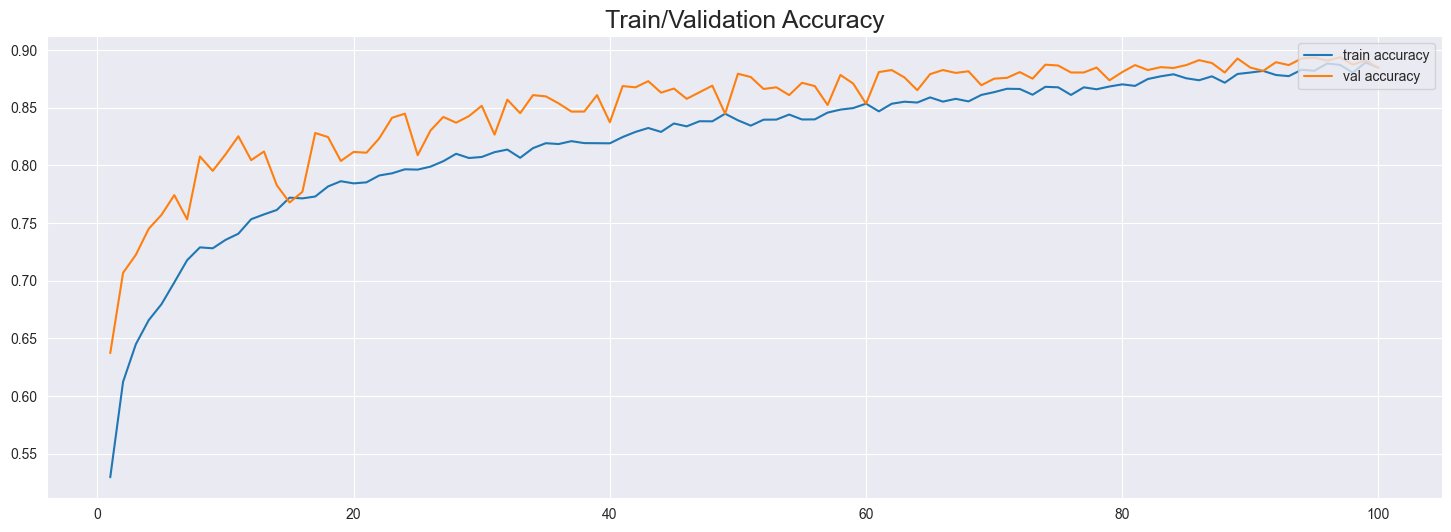

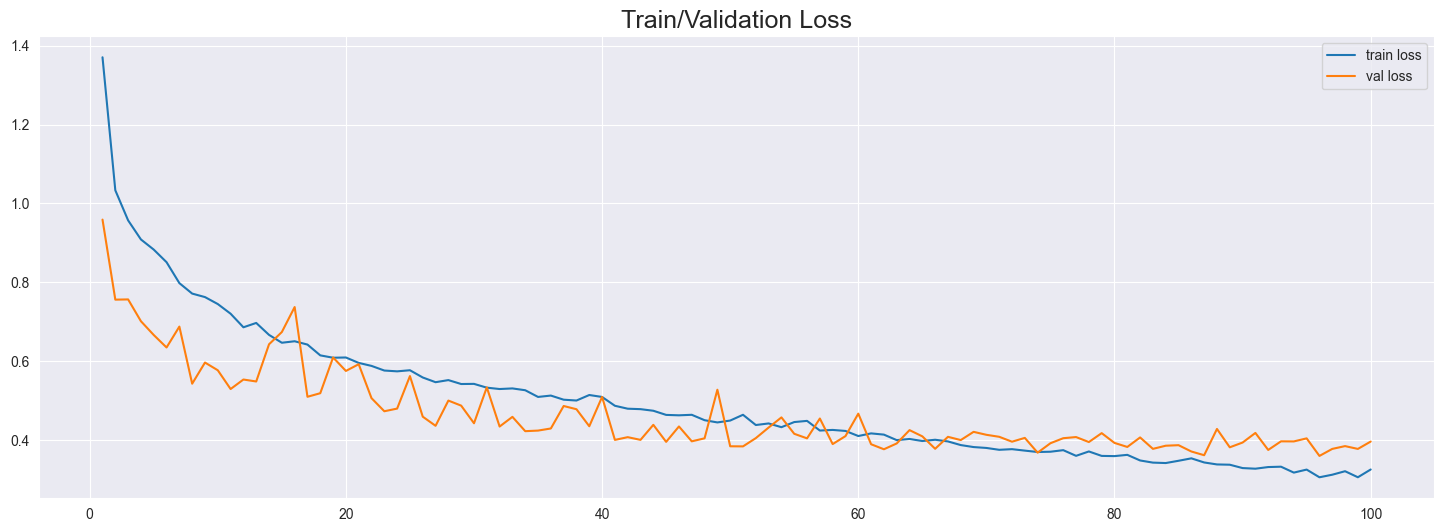

In [179]:
plt.figure(figsize=(18,6))
plt.plot(range(1,EPOCHS+1), train_accs, label='train accuracy')
plt.plot(range(1,EPOCHS+1), val_accs, label="val accuracy")
plt.legend(loc='upper right')
plt.title("Train/Validation Accuracy", fontsize=18)
plt.show()

plt.figure(figsize=(18,6))
plt.plot(range(1,EPOCHS+1), train_losses, label='train loss')
plt.plot(range(1,EPOCHS+1), val_losses, label="val loss")
plt.legend(loc='upper right')
plt.title("Train/Validation Loss", fontsize=18)
plt.show()

Save model

In [180]:
torch.save(model.state_dict(), "models/basic_CNN.pt")

Load model

In [204]:
model = CNN(num_classes=6)
model.load_state_dict(torch.load("models/basic_CNN.pt"))

<All keys matched successfully>

In [205]:
print(get_model_size(model))

21.65


In [206]:
statistics = pd.DataFrame(index=['size_of_model', 'accuracy', 'inference_time'],
                          columns=['not quantized',                                                                     'post-training dynamic q',                                                                   'post-training static q',                                                                      'QAT'])

In [207]:
statistics.loc['size_of_model']['not quantized']=get_model_size(model)

### Model evaluation

In [31]:
def evaluate(model, test_loader):
    '''
    computes predictions and probabilities of each prediction by batch
    and joins it in one big prediction and probability-vector
    :return: predictions, probs and targets
    '''
    predictions =[]
    probs = []
    targets = []
    softmax = nn.Softmax(dim=1)
    model.eval()

    for inputs, labels in test_loader:
        outputs = model(inputs)
        #compute probabilities
        y_probs = softmax(outputs)
        y_probs = y_probs.detach().numpy()
        #compute classes
        y_pred = y_probs.argmax(axis=1)

        predictions.extend(y_pred)
        probs.extend(y_probs)
        targets.extend(labels.numpy())


    return predictions, np.array(probs), targets



In [208]:
start_time= time.time() # set the time at which inference started
y_pred, y_probs, labels = evaluate(model, test_dataloader)
stop_time=time.time()
duration =stop_time - start_time

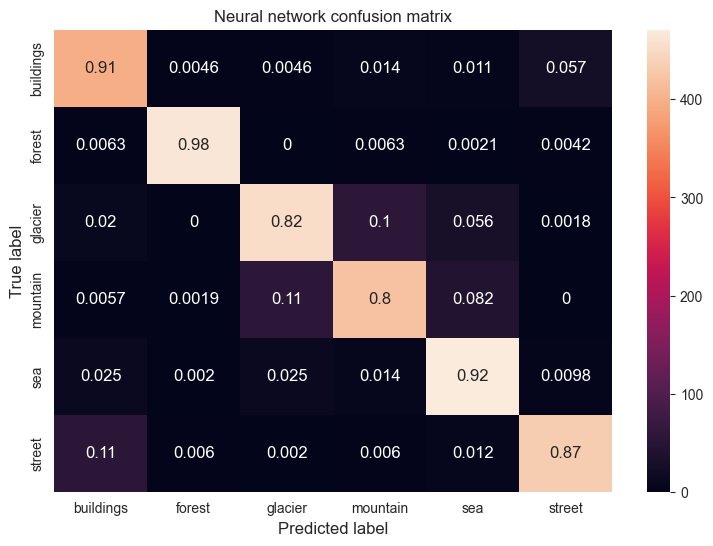

In [209]:
conf = confusion_matrix(labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=train_dataset.classes,
            xticklabels=train_dataset.classes,
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

In [210]:
print(classification_report(labels, y_pred, target_names=train_dataset.classes))

              precision    recall  f1-score   support

   buildings       0.83      0.91      0.86       437
      forest       0.99      0.98      0.98       474
     glacier       0.86      0.82      0.84       553
    mountain       0.85      0.80      0.82       525
         sea       0.85      0.92      0.88       510
      street       0.93      0.87      0.90       501

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



In [211]:
statistics.loc['accuracy']['not quantized']=accuracy_score(labels, y_pred)
statistics.loc['inference_time']['not quantized']=duration

In [212]:
statistics

,not quantized,post-training dynamic q,post-training static q,QAT
size_of_model,21.65,NaN,NaN,NaN
accuracy,0.880333,NaN,NaN,NaN
inference_time,13.17939,NaN,NaN,NaN


### Roc-AUC curves

In [112]:
auc_scores = calculate_auc_scores(labels, y_probs, train_dataset.classes)

### Roc-curves for each class

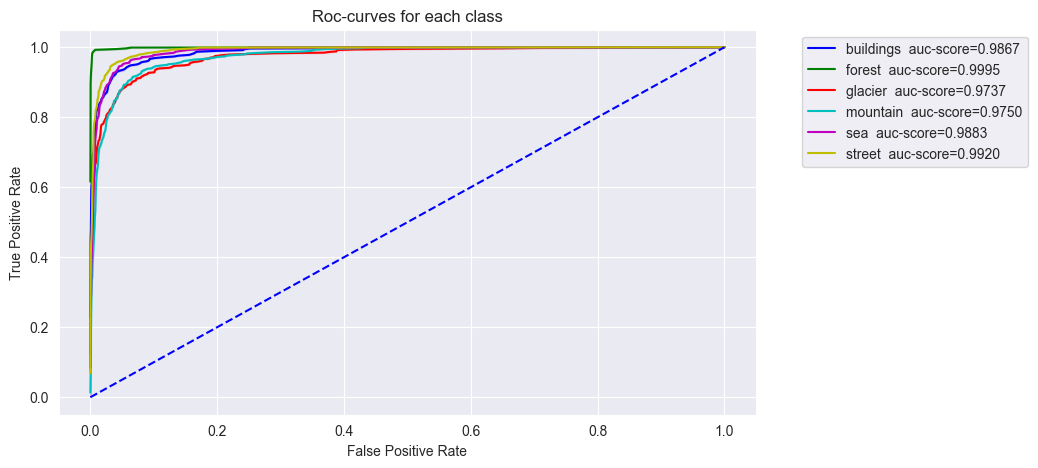

In [113]:
plot_roc_curves_ovr(labels, y_probs, train_dataset.classes, auc_scores)

### Precision-recall curves for each class

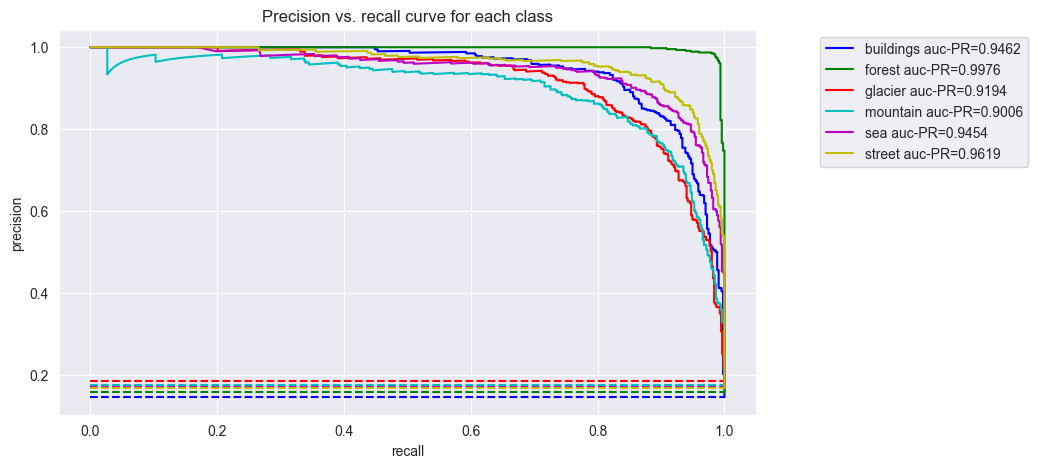

In [114]:
plot_precision_recall_curves(labels, y_probs, train_dataset.classes)

### Visualization of predictions

Show 20 random predictions from test set

In [117]:
X_test, labels = next(iter(test_dataloader))

outputs = model(X_test)
#compute probabilities
softmax = nn.Softmax(dim=1)
y_probs = softmax(outputs)
y_probs = y_probs.detach().numpy()
#compute classes
y_pred = y_probs.argmax(axis=1)

In [118]:
def show_predictions(X_test, labels, y_pred):
    '''
    shows 20 random images from X_test,
    untransform images back by multiplying by the std and adding mean.
    :param X_test: one batch of test set (64 random images)
    :param labels: true labels from that one batch
    :param y_pred: predicted labels
    '''
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    plt.figure(figsize=(20, 10))
    #choose random 20 pictures
    idx = np.random.randint(0, len(X_test), 20)
    for i, index in enumerate(idx):
        ax = plt.subplot(4, 5, i + 1)
        img=X_test[index].numpy().transpose((1,2,0));
        #inverse transformation from standartization
        img=img*std+mean;
        plt.imshow(img)
        true_label = train_dataset.classes[labels[index]]
        predicted_label = train_dataset.classes[y_pred[index]]
        color = "green" if true_label == predicted_label else "red"
        plt.title(f"Label: {true_label} \n Predicted: {predicted_label}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

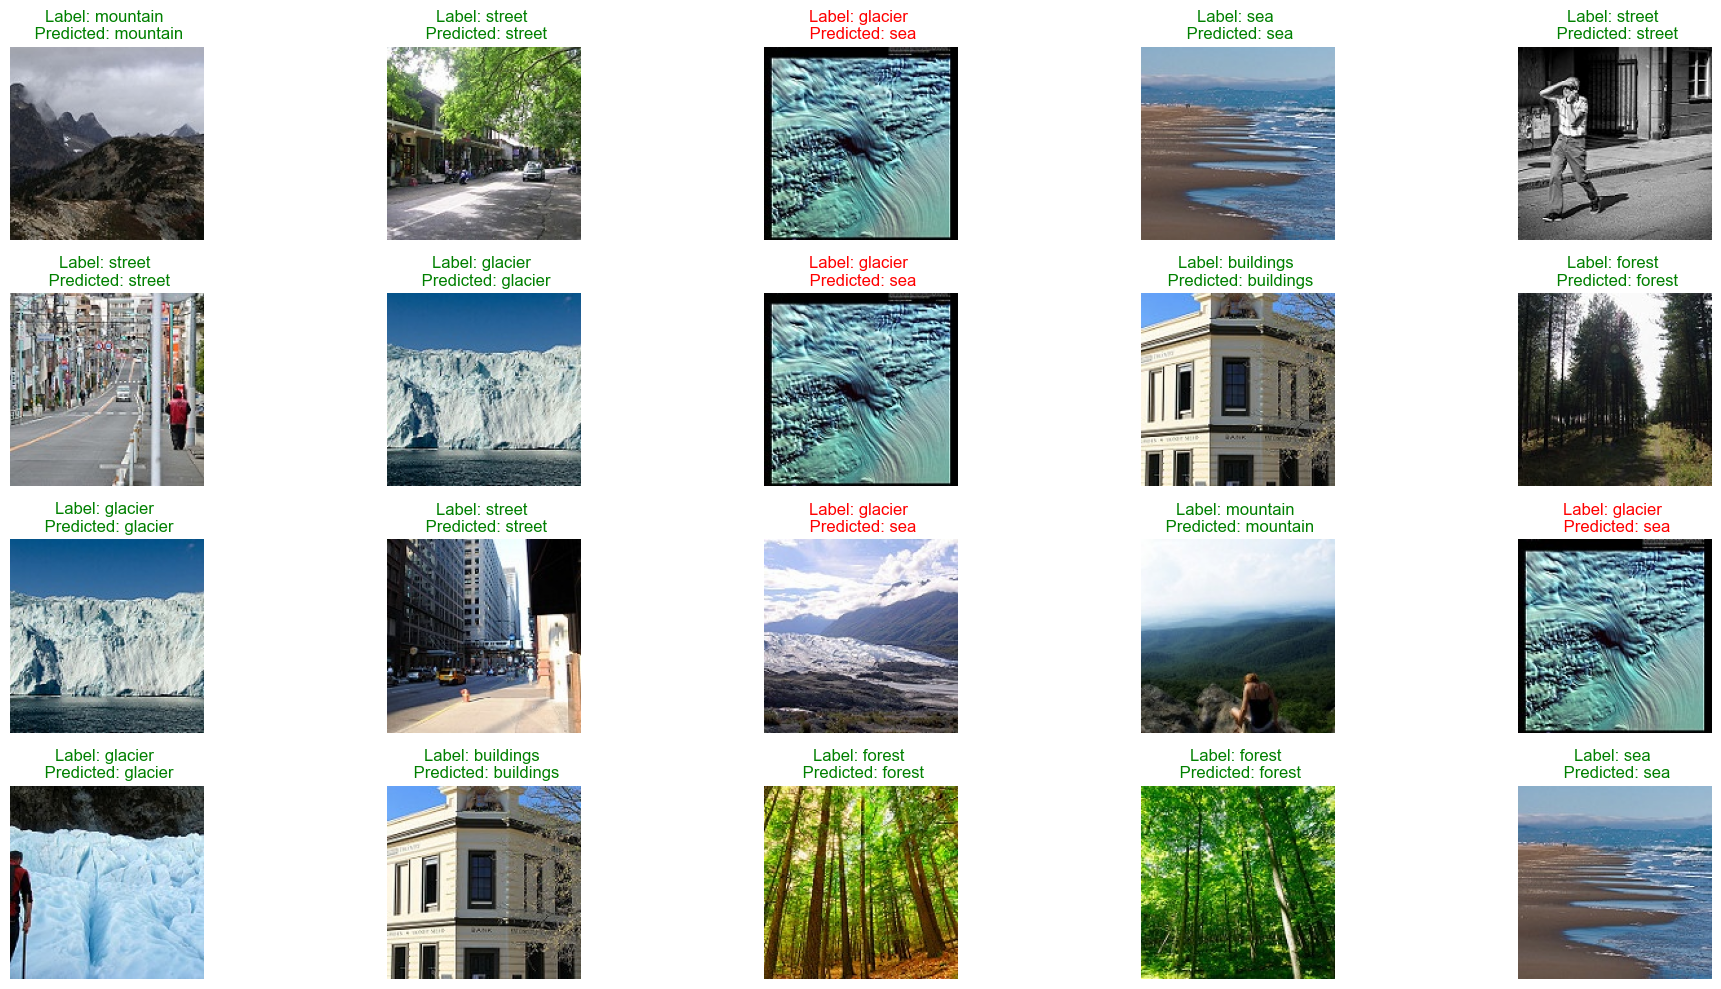

In [119]:
show_predictions(X_test, labels, y_pred)

We can see that in general base custom model showed good results in prediction. It mixed just glacier with sea.

# Quantization of model

## Post Training Dynamic Quantization

Perform only linear layers quantization

In [213]:
model_dynamic_quantized = torch.quantization.quantize_dynamic(
    model, qconfig_spec={torch.nn.Linear}, dtype=torch.qint8
)

In [214]:
print(get_model_size(model_dynamic_quantized))

5.72


In [216]:
statistics.loc['size_of_model']['post-training dynamic q']=get_model_size(model_dynamic_quantized)

The size of model has decreased by 4x.

### Look at model weights and biases before quantization

In [35]:
for name, param in model.named_parameters():
    print(f"{name}:")
    #print(param.detach().numpy())

convolutional_layers.0.weight:
convolutional_layers.0.bias:
convolutional_layers.2.weight:
convolutional_layers.2.bias:
convolutional_layers.4.weight:
convolutional_layers.4.bias:
convolutional_layers.6.weight:
convolutional_layers.6.bias:
convolutional_layers.8.weight:
convolutional_layers.8.bias:
convolutional_layers.10.weight:
convolutional_layers.10.bias:
convolutional_layers.12.weight:
convolutional_layers.12.bias:
convolutional_layers.14.weight:
convolutional_layers.14.bias:
dense_layers.1.weight:
dense_layers.1.bias:
dense_layers.4.weight:
dense_layers.4.bias:


### Check weights and biases of quantized model

In [36]:
for name, param in model_dynamic_quantized.named_parameters():
    print(f"{name}:")
    #print(param.detach().numpy())

convolutional_layers.0.weight:
convolutional_layers.0.bias:
convolutional_layers.2.weight:
convolutional_layers.2.bias:
convolutional_layers.4.weight:
convolutional_layers.4.bias:
convolutional_layers.6.weight:
convolutional_layers.6.bias:
convolutional_layers.8.weight:
convolutional_layers.8.bias:
convolutional_layers.10.weight:
convolutional_layers.10.bias:
convolutional_layers.12.weight:
convolutional_layers.12.bias:
convolutional_layers.14.weight:
convolutional_layers.14.bias:


In [217]:
start_time= time.time() # set the time at which inference started
y_pred, y_probs, labels = evaluate(model_dynamic_quantized, test_dataloader)
stop_time=time.time()
duration =stop_time - start_time

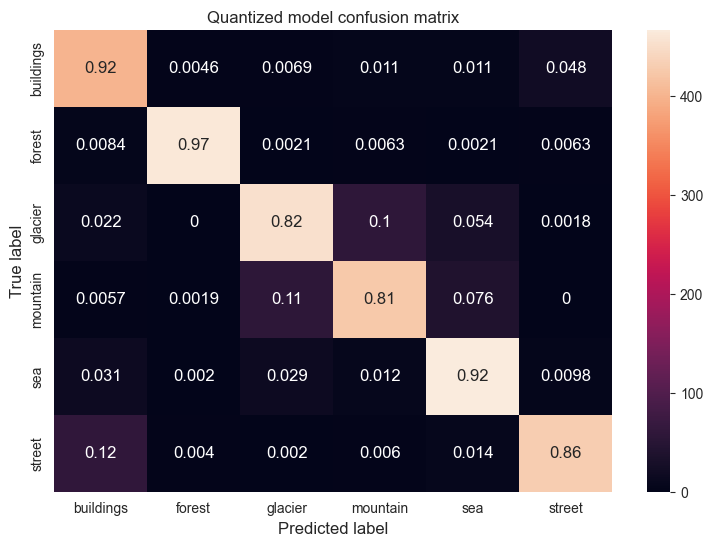

In [218]:
conf = confusion_matrix(labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=train_dataset.classes,
            xticklabels=train_dataset.classes,
            )
plt.title('Quantized model confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

The quality of model almost didn't change.

In [219]:
print(classification_report(labels, y_pred, target_names=train_dataset.classes))

              precision    recall  f1-score   support

   buildings       0.81      0.92      0.86       437
      forest       0.99      0.97      0.98       474
     glacier       0.86      0.82      0.84       553
    mountain       0.85      0.81      0.83       525
         sea       0.85      0.92      0.88       510
      street       0.93      0.86      0.89       501

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



In [220]:
statistics.loc['accuracy']['post-training dynamic q']=accuracy_score(labels, y_pred)
statistics.loc['inference_time']['post-training dynamic q']=duration

In [221]:
statistics

,not quantized,post-training dynamic q,post-training static q,QAT
size_of_model,21.65,5.72,NaN,NaN
accuracy,0.880333,0.879,NaN,NaN
inference_time,13.17939,12.96982,NaN,NaN


### Post-Training Static Quantization

First add additional lines of code into the model class for quantization

In [239]:
class CNN_Q(torch.nn.Module):
    def __init__(self, num_classes):
        super(CNN_Q, self).__init__()
        #add these quant and dequant for quantization
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

        self.convolutional_layers = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), #output 16x150x150
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.MaxPool2d(kernel_size=(2,2)),#output 16x75x75

            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.MaxPool2d(kernel_size=(2,2)), #output 32x37x37

            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.MaxPool2d(kernel_size=(2,2)), #output 64x18x18

            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.MaxPool2d(kernel_size=(2,2)), #output 128x9x9


        )

        #fully connected layer
        self.dense_layers = torch.nn.Sequential(
            nn.Flatten(),
            torch.nn.Linear(9*9*128, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, num_classes)
        )

    def forward(self, X):
        X = self.quant(X)
        out = self.convolutional_layers(X)
        out = self.dense_layers(out)
        out = self.dequant(out)
        return out

In [240]:
model = CNN_Q(num_classes=6)
model.load_state_dict(torch.load("models/basic_CNN.pt"))

<All keys matched successfully>

In [246]:
model.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')

# insert observers
model_static_quantized = torch.ao.quantization.prepare(model, inplace=False)

In [247]:
print(model.qconfig)

QConfig(activation=functools.partial(<class 'torch.ao.quantization.fake_quantize.FusedMovingAvgObsFakeQuantize'>, observer=<class 'torch.ao.quantization.observer.MovingAverageMinMaxObserver'>, quant_min=0, quant_max=255, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.fake_quantize.FusedMovingAvgObsFakeQuantize'>, observer=<class 'torch.ao.quantization.observer.MovingAveragePerChannelMinMaxObserver'>, quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})


In [248]:
# observers collect statistics on train data
model_static_quantized.eval()
with torch.no_grad():
    for data, target in train_dataloader:
        model_static_quantized(data)

In [249]:
# convert to quantized version
model_static_quantized = torch.quantization.convert(model_static_quantized, inplace=False)

In [250]:
get_model_size(model_static_quantized)

5.45

In [251]:
statistics.loc['size_of_model']['post-training static q']=get_model_size(model_static_quantized)

In [252]:
start_time= time.time() # set the time at which inference started
y_pred, y_probs, labels = evaluate(model_static_quantized, test_dataloader)
stop_time=time.time()
duration =stop_time - start_time

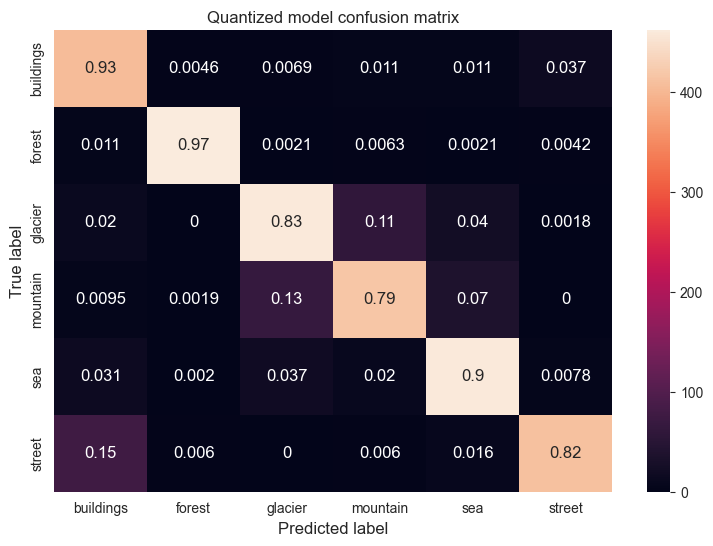

In [253]:
conf = confusion_matrix(labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=train_dataset.classes,
            xticklabels=train_dataset.classes,
            )
plt.title('Quantized model confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

In [254]:
print(classification_report(labels, y_pred, target_names=train_dataset.classes))

              precision    recall  f1-score   support

   buildings       0.78      0.93      0.85       437
      forest       0.99      0.97      0.98       474
     glacier       0.84      0.83      0.83       553
    mountain       0.84      0.79      0.81       525
         sea       0.86      0.90      0.88       510
      street       0.95      0.82      0.88       501

    accuracy                           0.87      3000
   macro avg       0.88      0.87      0.87      3000
weighted avg       0.88      0.87      0.87      3000



In [255]:
statistics.loc['accuracy']['post-training static q']=accuracy_score(labels, y_pred)
statistics.loc['inference_time']['post-training static q']=duration

In [256]:
statistics

,not quantized,post-training dynamic q,post-training static q,QAT
size_of_model,21.65,5.72,5.45,NaN
accuracy,0.880333,0.879,0.871333,NaN
inference_time,13.17939,12.96982,9.076153,NaN


## Quantization-Aware training

Define quantization inside the model class

Define the model with quantization

In [257]:
model = CNN_Q(num_classes=6)

In [258]:
model

CNN_Q(
  (quant): QuantStub()
  (dequant): DeQuantStub()
  (convolutional_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (

In [259]:
model.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')
model_qat = torch.quantization.prepare_qat(model.train(), inplace=False)

In [261]:
model_qat

CNN_Q(
  (quant): QuantStub(
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
      (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
    )
  )
  (dequant): DeQuantStub()
  (convolutional_layers): Sequential(
    (0): Conv2d(
      3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
        fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
        (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
      )
      (activation_

In [262]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_qat.parameters(), lr=0.001)
# optimization of learning rate by factor 0.9 if there is no improvement for 5 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=5, verbose=True)

Train model

In [263]:
EPOCHS = 100
train_losses, val_losses, train_accs, val_accs = train_CNN(model_qat, loss, optimizer, train_dataloader, val_dataloader,
                                                    EPOCHS)

Epoch 1/100  Train Loss: 1.9960  Train Acc:  0.2589 Val Loss: 8.9769 Val Acc:  0.2789 Duration: 0:06:11.425043
Epoch 2/100  Train Loss: 6.7760  Train Acc:  0.3986 Val Loss: 4.1896 Val Acc:  0.5335 Duration: 0:06:21.859063
Epoch 3/100  Train Loss: 6.7918  Train Acc:  0.4601 Val Loss: 5.5359 Val Acc:  0.5196 Duration: 0:06:16.213418
Epoch 4/100  Train Loss: 4.6377  Train Acc:  0.5179 Val Loss: 4.5016 Val Acc:  0.5442 Duration: 0:06:19.717819
Epoch 5/100  Train Loss: 2.9112  Train Acc:  0.5434 Val Loss: 3.4821 Val Acc:  0.5995 Duration: 0:06:33.474668
Epoch 6/100  Train Loss: 2.3046  Train Acc:  0.5681 Val Loss: 1.2944 Val Acc:  0.6566 Duration: 0:06:27.380782
Epoch 7/100  Train Loss: 1.3735  Train Acc:  0.5875 Val Loss: 0.9569 Val Acc:  0.6705 Duration: 0:06:31.072113
Epoch 8/100  Train Loss: 1.0426  Train Acc:  0.6202 Val Loss: 0.8500 Val Acc:  0.6541 Duration: 0:06:21.951078
Epoch 9/100  Train Loss: 0.9102  Train Acc:  0.6505 Val Loss: 0.7366 Val Acc:  0.7254 Duration: 0:06:24.688516
E

In [264]:
torch.save(model_qat.state_dict(), "models/basic_CNN_q.pt")

In [265]:
### Evaluation

In [266]:
model_qat = torch.quantization.convert(model_qat.eval(), inplace=False)

In [267]:
print_model_size(model_qat)

5.45 MB


In [268]:
statistics

,not quantized,post-training dynamic q,post-training static q,QAT
size_of_model,21.65,5.72,5.45,NaN
accuracy,0.880333,0.879,0.871333,NaN
inference_time,13.17939,12.96982,9.076153,NaN


In [269]:
statistics.loc['size_of_model']['QAT']=get_model_size(model_qat)

In [275]:
start_time= time.time() # set the time at which inference started
y_pred, y_probs, labels = evaluate(model_qat, test_dataloader)
stop_time=time.time()
duration =stop_time - start_time

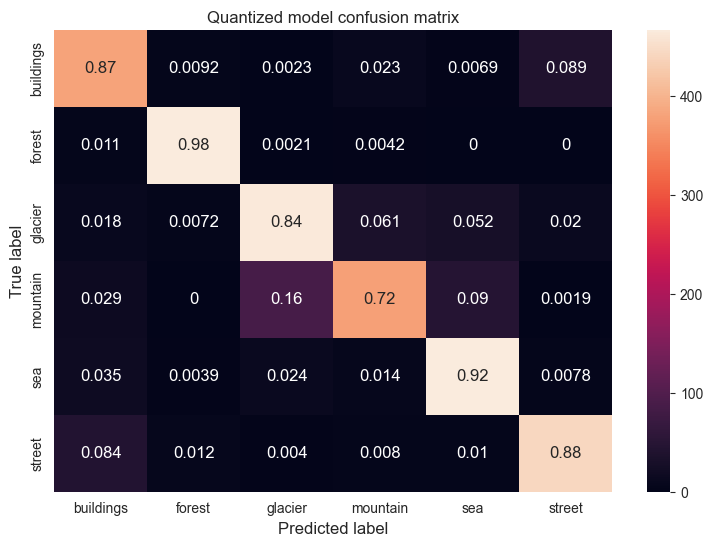

In [271]:
conf = confusion_matrix(labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=train_dataset.classes,
            xticklabels=train_dataset.classes,
            )
plt.title('Quantized model confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

In [272]:
print(classification_report(labels, y_pred, target_names=train_dataset.classes))

              precision    recall  f1-score   support

   buildings       0.81      0.87      0.84       437
      forest       0.97      0.98      0.97       474
     glacier       0.82      0.84      0.83       553
    mountain       0.87      0.72      0.78       525
         sea       0.85      0.92      0.88       510
      street       0.89      0.88      0.89       501

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.86      3000



In [276]:
statistics.loc['accuracy']['QAT']=accuracy_score(labels, y_pred)
statistics.loc['inference_time']['QAT']=duration

In [277]:
statistics

,not quantized,post-training dynamic q,post-training static q,QAT
size_of_model,21.65,5.72,5.45,5.45
accuracy,0.880333,0.879,0.871333,0.865333
inference_time,13.17939,12.96982,9.076153,9.137977


We got almost the same recall metrics: in some classes we got even better recal, for instance in **street** and **glacier**.

# Conclusions

In these HW I tried to use Classical Machine Learning approach for image classification and also Neural Networks approach.
For classical machine learning I used histograms of oriented gradients (HOGs) of images as features and later tried three classifiers:
* Logistic Regression
* KNN
* SVC

Among these classifiers the best result was for SVC (accuracy around 0.76) and the worst was for KNN (accuracy 0.47).

Neural networks approach showed better results. Here I tried my custom CNN (accuracy was 0.88), and pretrained VGG-19 model gave the best accuracy of 0.92 on test set.

For problems of such kind it is defenitely better to use Neural Networks approach.